**TODO:** 
- [ ] Rewrite the code for stable matching.
- [ ] Apply NMS after Stable mathing.

**Single Image test on NIDS with Sliding window**

In [1]:
# demo_eval_gdino_FFA.py
import glob
import json
import logging
import os
import sys
import random
import numpy as np
# import matplotlib.pyplot as plt
import torch
from torch import nn
# import torch.backends.cudnn as cudnn
# from torchvision import transforms as pth_transforms
# import torchvision.transforms as T
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
# from utils.visualizer import ColorMode, Visualizer
# from utils.instance_det_dataset import RealWorldDataset
from utils.inference_utils import compute_similarity, stableMatching, getColor, create_instances, nms, apply_nms, get_features
from tqdm import trange
# from adapter import ModifiedClipAdapter, WeightAdapter
# from utils.img_utils import get_masked_image
import numpy as np
from PIL import Image
import time
from absl import app, logging
from PIL import Image as PILImg
import PIL.ImageOps
from robokit.utils import overlay_masks
from robokit.ObjDetection import GroundingDINOObjectPredictor, SegmentAnythingPredictor
import torch
import supervision as sv
import tqdm as tqdm
from utils.img_utils import masks_to_bboxes
from utils.sliding_window import slice_image, get_slice_bboxes, get_object_features_and_proposals
from utils.changed_fn import area, annotate, get_object_proposal
import re

sys.path.append("../detectron2")
sys.path.append(".")

# Change this accordingly 
scene_level = 'all'  # all / easy / hard
test_path = "C:/dataset/InsDet-FULL/Data/test_1_"+scene_level
output_dir = 'D:/CODE/NIDS-Net/feats'
json_filename = 'high_resolution_object_features_vitl14_reg.json' # This file should be in output dir
results_filename = "highres_instances_results"
final_results_filename = "final_sliding_highres_instances_results"

In [2]:
imsize = 448
image_dir = []
source_dir = os.path.join(test_path, 'images')

image_paths = sorted([p for p in glob.glob(os.path.join(source_dir, '*'))
                      if re.search('/*\.(jpg|jpeg|png|gif|bmp|pbm)', str(p))])
image_dir.extend(image_paths)

In [3]:
gdino = GroundingDINOObjectPredictor(use_vitb=False, box_threshold=0.2, text_threshold=0.2)
SAM = SegmentAnythingPredictor(vit_model="vit_h") 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14_reg').to(device).eval()

final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\divya\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


Using cache found in C:\Users\divya/.cache\torch\hub\facebookresearch_dinov2_main
INFO:dinov2:using MLP layer as FFN


In [4]:
scene_features_list = []
proposals_list = []
scene_name_list = []

for image_path in image_dir:
    scene_features = []
    proposals = []
    start_time = time.time()
    text_prompt = 'objects'
    threshold = 20
    overlap_ratio_h=0.2
    overlap_ratio_w=0.2
    scene_name = os.path.basename(image_path).split('.')[0]

    image_pil = PILImg.open(image_path).convert("RGB") # Read Img
    wd, ht = image_pil.size

    if wd==640 and ht==480:
        image_pil = PILImg.open(image_path).convert("RGB").resize(((8192//2), (6144//2)), PIL.Image.BILINEAR) 

        image = Image.new(image_pil.mode, (8192, 6144), (225, 225, 255))
        image.paste(image_pil, (8192//4, 6144//4)) 
        width, height = image.size # Get size of Image
        slice_height = height // 2
        slice_width = width // 2
        threshold = 35
        
    else:
        image=image_pil
        threshold = 15
        width, height = image.size # Get size of Image
        slice_height = height // 3
        slice_width = width // 3

    slice_image_result = slice_image(
                image=image,
                slice_height=slice_height,
                slice_width=slice_width,
                overlap_height_ratio=overlap_ratio_h,
                overlap_width_ratio=overlap_ratio_w,
                auto_slice_resolution=False,
            )

    all_windows = get_slice_bboxes(
            image_height=height,
            image_width=width,
            slice_height=slice_height,
            slice_width=slice_width,
            auto_slice_resolution=False,
            overlap_height_ratio=overlap_ratio_h,
            overlap_width_ratio=overlap_ratio_w
        )

    number_of_tiles = len(slice_image_result)
    logging.info(f" Read {scene_name} Image and created {number_of_tiles} Windows")
    
    scene_features, proposals = get_object_features_and_proposals(
        image_path, 
        all_windows, 
        threshold,
        slice_image_result, 
        gdino, 
        text_prompt, 
        SAM, 
        encoder,
        imsize,
        output_dir
    )

    scene_features_list.append(scene_features)
    proposals_list.append(proposals)
    scene_name_list.append(scene_name)
    torch.cuda.empty_cache()
    end_time = time.time()
    logging.info(f" Total running time for {scene_name}: {(end_time - start_time)/60:.02} mins")
    logging.info("-"*100)

INFO:absl: Read test_000 Image and created 16 Windows
16it [01:16,  4.77s/it]
INFO:absl: Total running time for test_000: 1.3 mins
INFO:absl:----------------------------------------------------------------------------------------------------
INFO:absl: Read test_001 Image and created 16 Windows
16it [01:19,  4.97s/it]
INFO:absl: Total running time for test_001: 1.4 mins
INFO:absl:----------------------------------------------------------------------------------------------------
INFO:absl: Read test_002 Image and created 16 Windows
16it [01:18,  4.89s/it]
INFO:absl: Total running time for test_002: 1.3 mins
INFO:absl:----------------------------------------------------------------------------------------------------
INFO:absl: Read test_003 Image and created 16 Windows
16it [01:04,  4.04s/it]
INFO:absl: Total running time for test_003: 1.1 mins
INFO:absl:----------------------------------------------------------------------------------------------------
INFO:absl: Read test_004 Image a

In [5]:
del gdino
del SAM
del encoder
torch.cuda.empty_cache()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open(os.path.join(output_dir, json_filename), 'r') as f:
    feat_dict = json.load(f)

object_features = torch.Tensor(feat_dict['features']).to(device)
object_features = nn.functional.normalize(object_features, dim=1, p=2)

print("object_features: ", object_features.shape) # Shape (2400, 1024)

object_features:  torch.Size([2400, 1024])


In [7]:
assert len(scene_features_list)==len(proposals_list)
results_list=[]

for idx in trange(len(scene_features_list)):
   
    num_object = 100 # len(object_dataset.cfg['obj_name'])
    # Reduce this num_example value and find out which is the minimum no. of image instances that can be used without reducing the accuracy of the architecture. 
    num_example = len(object_features) // num_object # 24 each object instances 

    sim_mat = compute_similarity(object_features, scene_features_list[idx])
    sim_mat = sim_mat.view(len(scene_features_list[idx]), num_object, num_example)
    sims, _ = torch.max(sim_mat, dim=2)  # choose max score over profile examples of each object instance
    sims = sims.view(len(scene_features_list[idx]), num_object)
    max_ins_sim, initial_result = torch.max(sims, dim=1)

    proposals = proposals_list[idx]
    num_proposals = len(proposals)
    # print("Similarity Matrix: ", sims.shape) # (n, 100)

    # TODO 1: Rewite Matching script 
    # TODO 2: Find best threshold THRESHOLD_OBJECT_SCORE value
    results = []


    ########################################## Stable Matching Strategy ##########################################
    do_matching = False
    if do_matching:
        
        # ------------ ranking and sorting ------------
        # Initialization
        sel_obj_ids = [str(v) for v in list(np.arange(num_object))]  # ids for selected obj
        sel_roi_ids = [str(v) for v in list(np.arange(len(scene_features_list[idx])))]  # ids for selected roi
        print(f"{len(sel_obj_ids)} || {len(sel_roi_ids)}")
        # Padding
        # max_len = max(len(sel_roi_ids), len(sel_obj_ids)) # l = max(n-1, 99)
        sel_sims_symmetric = torch.ones((len(sel_roi_ids), len(sel_obj_ids))) * -1  # Create a l * l matrix filled with -1 
        sel_sims_symmetric[:len(sel_roi_ids), :len(sel_obj_ids)] = sims.clone() # clone the sims matrix into this new created matrix
        # len(sel_roi_ids)=n || len(sel_obj_ids)=100
        print(f"{sel_sims_symmetric.shape}")
        """
        if n=98
        sims.shape=(98,100)
        len(sel_roi_ids)=98 < len(sel_obj_ids)=100
        max_len=100
        sel_sims_symmetric.shape=(100,100)  >>>>> (98,100)
        sel_sims_symmetric[:98, :100] = sims.clone() # last 2 rows empty
        
        
        ~pad_len = 2
        ~pad_roi_ids = [98,99] # for i from 98 to 100 # created extra rois which doesnt exists for "padding"
        
        
        len(sel_roi_ids)=100 
        matchedMat.shape=(100,100) # scores for obj * roi   >>>>> (98,100)
        predMat_row.shape=(100,100) # all zero's array      >>>>> (98,100)
        Matches = {} len(items of matches)=100 >>>>> THis has changed to 98 
        for i in 0-100 this is on roi dim
            tmp=[0,:] # get all the 100 object scores for single roi in tmp
            a = argmax(tmp) # a contains the index of the max score object 
            predMat_row[0,a] = tmp[a] # store the obj id in predMat at roi_id X a (i.e the obj_id)
            Store this tuple (roi_id,a) in Matches        

        """
        
        # pad_len = abs(len(sel_roi_ids) - len(sel_obj_ids))
        # if len(sel_roi_ids) > len(sel_obj_ids):
        #     pad_obj_ids = [str(i) for i in range(num_object, num_object + pad_len)]
        #     sel_obj_ids += pad_obj_ids
        # elif len(sel_roi_ids) < len(sel_obj_ids):
        #     pad_roi_ids = [str(i) for i in range(len(sel_roi_ids), len(sel_roi_ids) + pad_len)]
        #     sel_roi_ids += pad_roi_ids

        # ------------ stable matching ------------
        matchedMat = stableMatching(sel_sims_symmetric.detach().data.cpu().numpy())  # predMat is raw predMat
        
        predMat_row = np.zeros_like(sel_sims_symmetric.detach().data.cpu().numpy())  # predMat_row is the result after stable matching
        
        print(f"{matchedMat.shape=}")

        Matches = dict()
        for i in range(matchedMat.shape[0]):
            tmp = matchedMat[i, :]
            a = tmp.argmax()
            predMat_row[i, a] = tmp[a]
            Matches[sel_roi_ids[i]] = sel_obj_ids[int(a)]
        print("Stable Matching Done!")
        print(f"{predMat_row.shape=}, {len(Matches.items())}")
        # ------------ thresholding ------------
        preds = Matches.copy()

        # ------------ save per scene results ------------
        for i, (k, v) in enumerate(preds.items()): # K is my roi id and v is my obj id 
            if int(k) >= num_proposals:  # since the number of proposals is less than the number of object features
                break
            result = dict()
            result['image_id'] = proposals[int(k)]['image_id']
            result['category_id'] = int(v)
            result['bbox'] = proposals[int(k)]['bbox']
            result['area'] = proposals[int(k)]['area']
            result['score'] = float(sims[int(k), int(v)])
            result['image_width'] = proposals[int(k)]['image_width']
            result['image_height'] = proposals[int(k)]['image_height']
            result['scale'] = proposals[int(k)]['scale']
            results.append(result)

    else:
        THRESHOLD_OBJECT_SCORE = 0.6
        for i in range(num_proposals):
            if float(max_ins_sim[i]) < THRESHOLD_OBJECT_SCORE:
                continue
            result = dict()
            result['image_id'] = proposals[i]['image_id']
            result['category_id'] = initial_result[i].item()
            result['bbox'] = proposals[i]['bbox']
            result['area'] = proposals[i]['area']
            result['score'] = float(max_ins_sim[i])
            result['image_width'] = proposals[i]['image_width']
            result['image_height'] = proposals[i]['image_height']
            result['scale'] = proposals[i]['scale']
            results.append(result)
        # print("Done!")
    
    # print("Objects Matched: ",len(results))
    results_list.append(results)

100%|██████████| 160/160 [00:44<00:00,  3.56it/s]


In [ ]:
# Apply NMS: https://medium.com/analytics-vidhya/non-max-suppression-nms-6623e6572536

In [8]:
with open(os.path.join(output_dir,results_filename+".json"), "w") as f:
    json.dump(results_list, f)

predictions = dict(
    [(k, {'image_id': -1, 'instances': []}) for k in range(len(scene_name_list))])


for idx in range(len(results_list)):
    id = results_list[idx][0]['image_id']
    predictions[scene_name_list.index('test_' + str(id).zfill(3))]['image_id'] = int(id)
    for j in range(len(results_list[idx])):   
        predictions[scene_name_list.index('test_' + str(id).zfill(3))]['instances'].append(results_list[idx][j])

torch.save(predictions, os.path.join("instances_predictions.pth"))
print('Saved instances_predictions.pth')

random.seed(77)
thing_colors = []
for i in range(100):
    thing_colors.append(getColor())

Saved instances_predictions.pth


In [9]:
with open(os.path.join(output_dir,results_filename+".json"), 'r') as f:
    annotations = json.load(f)
    
final_annotations=[]
for a in annotations:
    final_annotations.extend(a)

for i in range(len(final_annotations)):
    final_annotations[i]['id'] = i
print(len(final_annotations))

with open(os.path.join(test_path, 'instances_test_4_'+scene_level+'.json'), 'r') as f:
    GTannotations = json.load(f)

final = {}
final['info']=GTannotations['info']
final['images']=GTannotations['images']
final['annotations']=final_annotations

with open(os.path.join(output_dir,final_results_filename+".json"), "w") as f:
    json.dump(final, f)

6809


In [10]:
test_images_path = os.path.join(test_path, 'images')  # 1 for raw data, 2 for ratio=0.5, 4 for ratio=0.25, 8 for ratio=0.125
GT_json = os.path.join(test_path, 'instances_test_4_'+scene_level+'.json')
register_coco_instances("coco_InsDet_test", {}, GT_json, test_images_path)
MetadataCatalog.get("coco_InsDet_test").thing_colors = thing_colors

## evaluate the results using COCO API
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Load the ground truth COCO dataset
cocoGt = COCO(GT_json)

# Load your detection results
cocoDt = COCO(os.path.join(output_dir,final_results_filename+".json"))
# Create a COCOeval object by initializing it with the ground truth and detection results
cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')

# Run the evaluation
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.96s).
Accumulating evaluation results...
DONE (t=0.72s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.528
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.682
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.753
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

 100% |█████████████████| 160/160 [4.8s elapsed, 0s remaining, 27.2 samples/s]      



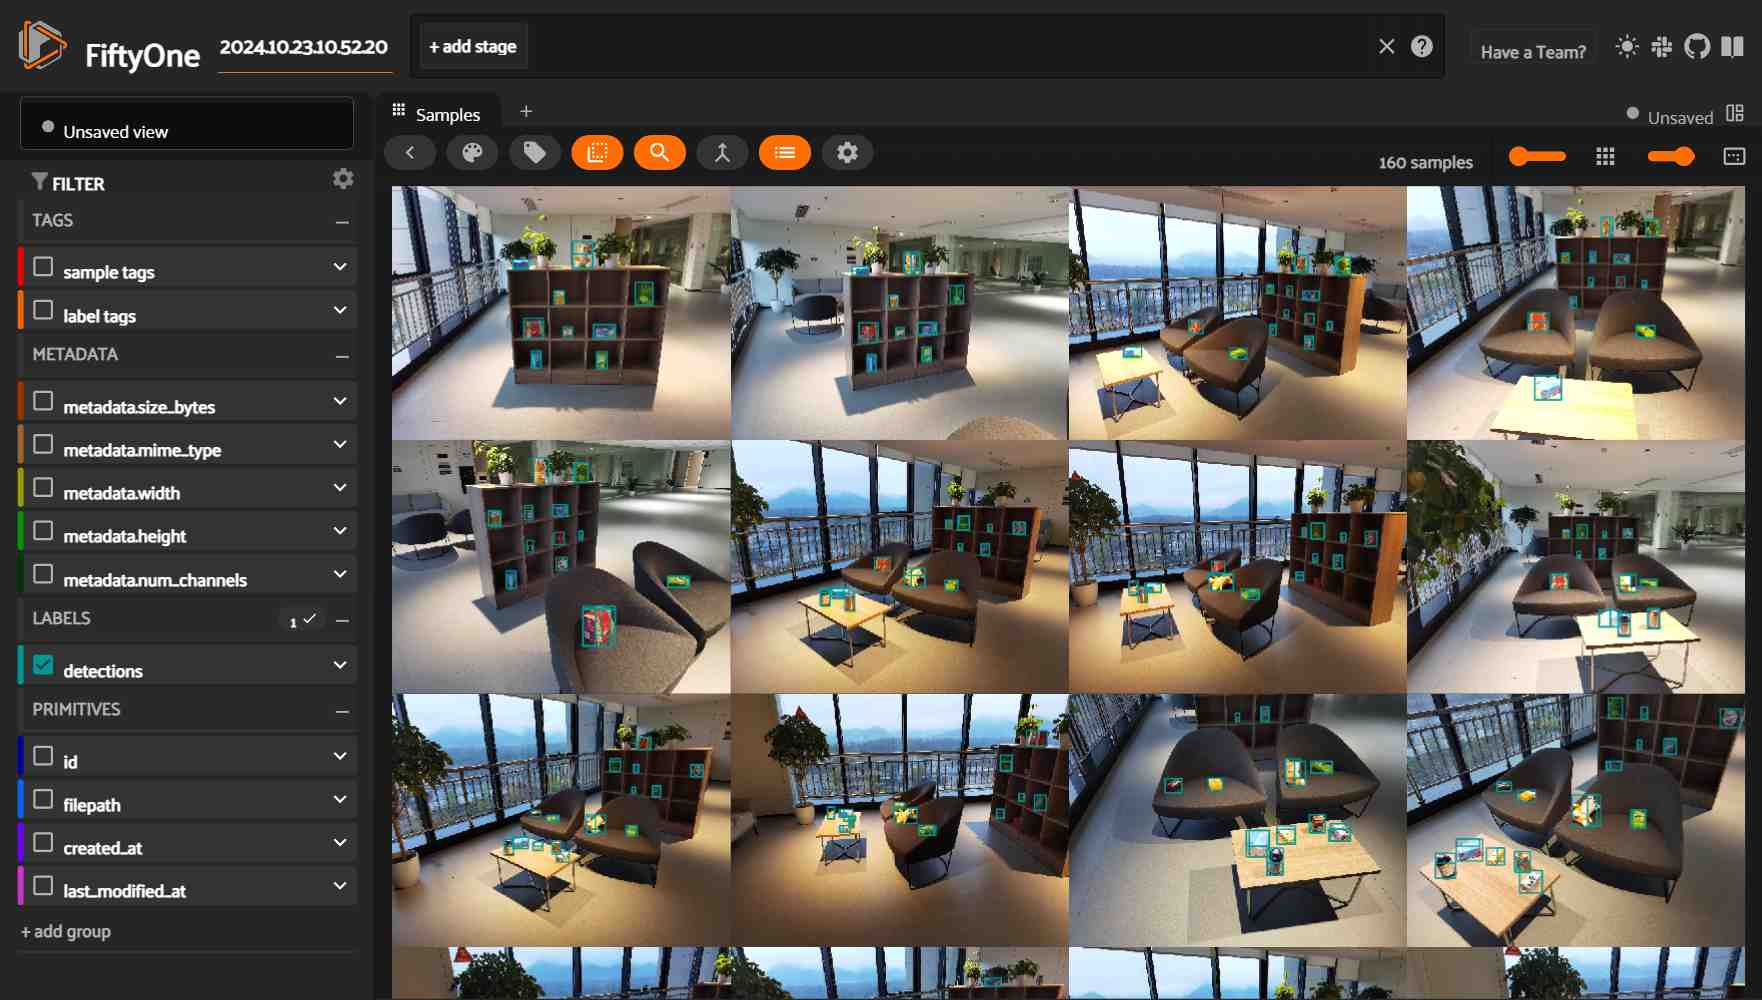

In [7]:
import fiftyone as fo

# A name for the dataset
name = "High-Res-Dataset"
img_dir = os.path.join(test_path, 'images')
gt_dir = os.path.join(test_path, 'instances_test_4_'+scene_level+'.json')
pred_dir = os.path.join(os.path.join(output_dir,final_results_filename+".json"))

dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=img_dir,
    labels_path=pred_dir, # Select weather u want to see GT or Pred (I can't figure out a way to put them both, without running model)
)

session = fo.launch_app(dataset)

In [8]:
session.freeze()